# A Teaser Example

Let's start with a very reduced example that highlights some of the key capabilities of physics-based learning approaches.

Take a look at the following picture - the desired solution is shown in light gray. If we don't take care we'll learn an approximation like the red one shown on the left, which is completely off! With an improved learning setup, ideally by using a discretized numerical solver, we can at least accurately represent a part of the solutions (shown in green on the right).

```{figure} resources/intro-teaser-side-by-side.png
---
height: 240px
name: intro-teaser-side-by-side
---
Side by side - supervised versus differentiable physics training.
```


## Differentiable physics

One of the key concepts of the following chapters is what we'll call _differentiable physics_ (DP). This means that we use domain knowledge in the form of model equations, and then integrate discretized versions of these models into the training process. As implied by the name, having differentiable formulations is crucial for this process to support the training of neural networks.

Let's illustrate the properties of deep learning via DP with the following example: We'd like to find an unknown function $f^*$ that generates solutions from a space $Y$, taking inputs from $X$, i.e. $f^*: X \to Y$. In the following, we'll often denote _idealized_, and unknown functions with a $*$ superscript, in contrast to their discretized, realizable counterparts without this superscript. 

Let's additionally assume we have a generic differential equation $\mathcal P^*: Y \to Z$ (our _model_ equation), that encodes a property of the solutions, e.g. some real world behavior we'd like to match. Later on, $P^*$ will represent time evolutions, but it could also be a constraint for conservation of mass (then $\mathcal P^*$ would measure divergence). But to keep things as simple as possible here, the model we'll look at in the following is a mapping back to the input space $X$, i.e. $\mathcal P^*: Y \to X$.

Using a neural network $f$ to learn the unknown and ideal function $f^*$, we could turn to classic _supervised_ training to obtain $f$ by collecting data. This classical setup requires a dataset by sampling $x$ from $X$ and adding the corresponding solutions $y$ from $Y$. We could obtain these, e.g., by classical numerical techniques. Then we train the NN $f$ in the usual way using this dataset. 

In contrast to this supervised approach, employing differentiable physics takes advantage of the fact that we can directly use a discretized version of the physical model $\mathcal P$ and employ it to guide the training of $f$. I.e., we want $f$ to _interact_ with our _simulator_ $\mathcal P$. This can vastly improve the learning, as we'll illustrate below with a very simple example (more complex ones will follow later on).

Note that it order for the DP approach to work, $\mathcal P$ has to differentiable, as implied by the name. These differentials, in the form of a gradient, are what's driving the learning process.


## Finding the inverse function of a parabola

To illustrate these two approaches, we consider the following simplified setting: Given the function $\mathcal P: y\to y^2$ for $y$ in the inverval $[0,1]$, find the unknown function $f$ such that $\mathcal P(f(x)) = x$ for all $x$ in $[0,1]$. Note: to make things a bit more interesting, we're using $y^2$ here instead of the more common $x^2$ parabola, and the _discretization_ is simply given by representing the $x$ and $y$ via floating point numbers in the computer for this simple case.

We know possible solutions for $f$ are the positive or negative square root function (for completeness: piecewise combinations would also be possible).
We can try to solve this by using a neural network to approximate the inverse mapping $f$.
Let's start with the supervised approach.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

For supervised training, we can employ use our solver $\mathcal P$ for the problem to pre-compute the solutions we need for training: We randomly choose between the positive and the negative square root. This resembles the  general case, where we would use optimization techniques to compute this the solutions. These methods are not expected to favor one particular mode in multimodal solutions.

In [2]:
# X-Data
N = 200
X = np.random.random(N)

In [3]:
# Generation Y-Data
sign = (- np.ones((N,)))**np.random.randint(2,size=N)
Y = np.sqrt(X) * sign

Now we can define a network, loss, and training configuration. We'll use a simple `keras` model with three hidden layers, ReLU activations.

In [4]:
# Neural network
act = tf.keras.layers.ReLU()
model_sv = tf.keras.models.Sequential([
  tf.keras.layers.Dense(8, activation=act),
  tf.keras.layers.Dense(8, activation=act),
  tf.keras.layers.Dense(1,activation='linear')])

And we can start training via a simple mean squared error loss, using keras `fit` function:

In [5]:
# Loss function
loss_sv = tf.keras.losses.MeanSquaredError()
model_sv.compile(optimizer='adam', loss=loss_sv)

# Training
results_sv = model_sv.fit(X, Y, epochs=5, batch_size= 5,verbose=1)

Epoch 1/5
40/40 [==============================] - 0s 842us/step - loss: 0.5951
Epoch 2/5
40/40 [==============================] - 0s 1ms/step - loss: 0.5594
Epoch 3/5
40/40 [==============================] - 0s 1ms/step - loss: 0.5462
Epoch 4/5
40/40 [==============================] - 0s 1ms/step - loss: 0.5404
Epoch 5/5
40/40 [==============================] - 0s 965us/step - loss: 0.5379


As both model and data set are very small, the training converges very quickly, but if we inspect the predictions of the network, we can see that it nowhere near the solution we were hoping to find: it averages between the data points on both sides of the x-axis and therefore, fails to find satisfying solutions to our above problem.

The following plots nicely highlights this: it shows the data in blue, and the supervised solution in red. 

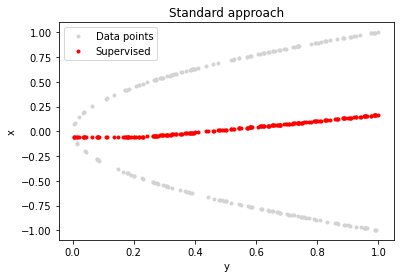

In [6]:
# Results
plt.plot(X,Y,'.',label='Data points', color="lightgray")
plt.plot(X,model_sv.predict(X),'.',label='Supervised', color="red")
plt.xlabel('y')
plt.ylabel('x')
plt.title('Standard approach')
plt.legend()
plt.show()

😱 This is obviously completely wrong! The red solution is nowhere near one of the two modes of our solution shown in gray.

Note that the red line is often not perfectly at zero, which is where the two modes of the solution should average out in the continuous setting. This is caused by the relatively coarse sampling with only 200 points in this example.
<br>

---

## A differentiable physics approach

Now let's apply a differentiable physics approach to find $f$: we'll directly include our discretized model $\mathcal P$ in the training. 

There is no real data generation step; we only need to sample from the $[0,1]$ interval. We'll simply keep the same $x$ locations used in the previous case, and a new instance of a model with the same architecture as before `model_dp`:

In [13]:
# X-Data
# X = X , we can directly re-use the X from above, nothing has changed...
# Y is evaluated on the fly

# Model
model_dp = tf.keras.models.Sequential([
  tf.keras.layers.Dense(8, activation=act),
  tf.keras.layers.Dense(8, activation=act),
  tf.keras.layers.Dense(1, activation='linear')])

The loss function is the crucial point for training: we directly incorporate the function f into the loss. In this simple case, the `loss_dp` function simply computes the square of the prediction `y_pred`. 

Later on, a lot more could happen here: we could evaluate finite difference stencils on the predicted solution, or compute a whole implicit time-integration step of a solver. Here we have a simple _mean-squared error_ term of the form $|y_{\text{pred}}^2 - y_{\text{true}}|^2$, which we are minimizing during training. It's not necessary to make it so simple: the more knowledge and numerical methods we can incorporate, the better we can guide the training process.

In [14]:
#Loss
mse = tf.keras.losses.MeanSquaredError()
def loss_dp(y_true, y_pred):
    return mse(y_true,y_pred**2)

model_dp.compile(optimizer='adam', loss=loss_dp)

In [15]:
#Training
results_dp = model_dp.fit(X, X, epochs=5, batch_size= 5,verbose=1)

Epoch 1/5
40/40 [==============================] - 0s 1ms/step - loss: 0.2260
Epoch 2/5
40/40 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 3/5
40/40 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 4/5
40/40 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 5/5
40/40 [==============================] - 0s 1ms/step - loss: 0.0014


Now the network actually has learned a good inverse of the parabola function! The following plot shows the solution in green.

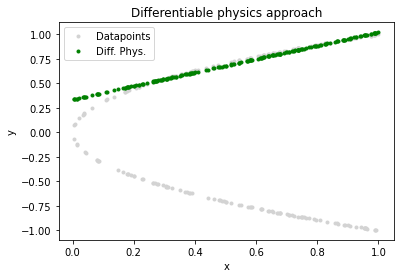

In [16]:
# Results
plt.plot(X,Y,'.',label='Datapoints', color="lightgray")
#plt.plot(X,model_sv.predict(X),'.',label='Supervised', color="red") # optional for comparison
plt.plot(X,model_dp.predict(X),'.',label='Diff. Phys.', color="green") 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Differentiable physics approach')
plt.legend()
plt.show()

This looks much better 😎, at least in the range of 0.1 to 1. 

What has happened here?

- We've prevented an undesired averaging of multiple modes in the solution by evaluating our discrete model w.r.t. current prediction of the network, rather than using a pre-computed solution. This let's us find the best single mode near the network prediction, and prevents an averaging of the modes that exist in the solution manifold.

- We're still only getting one side of the curve! This is to be expected, because we're representing the solutions with a deterministic function. Hence we can only represent a single mode. Interestingly, whether it's the top or bottom mode is determined by the random initialization of the weights in $f$ - run the example a couple of time to see this effect in action. To capture multiple modes we'd need to extend the model to capture the full distribution of the outputs and parametrize it with additional dimensions.

- The region with $x$ near zero is typically still off in this example. The model primarily learns a linear approximation of one half of the parabola here. This is primarily caused by the weak neural network: it is very small and shallow. (Give it a try - it's very easy to fix this in the `model_dp` defition.)


## Discussion

It's a very simple example, but it very clearly shows a failure case for supervised learning. While it might seem very artificial on first sight, many practical PDEs exhibit a variety of these modes, and it's often not clear where (and how many) exist in the solution manifold we're interested in. Using supervised learning is very dangerous in such cases - we might simply and unknowingly _blur_ out these different modes.

A good and obvious example are bifurcations in fluid flows - the smoke rising above a candle will start out straight, and then, due to tiny perturbations in its motion, start oscillating in a random direction. The images below illustrate this case via _numerical perturbations_: the perfectly symmetric setup will start turning left or right, depending on how the approximation errors build up. Similarly, we'll have different modes in all our numerical solutions, and typically it's important to recover them, rather than averaging them out. Hence, we'll show how to leverage training via _differentiable physics_ in the following chapters for more practical and complex cases.

```{figure} resources/intro-fluid-bifurcation.jpg
---
height: 240px
name: intro-fluid-bifurcation 
---
A bifurcation in a buoyancy-driven fluid flow: the "smoke" shown in green color starts rising in a percectly straight manner, but tiny numerical inaccuracies grow over time to lead to an instability with vortices alternating to one side (top-right), or in the opposite direction (bottom-right). 
```


## Next steps

For each of the following notebooks, there's a "next steps" section like the one below which contains recommendations about where to start modifying the code. After all, the whole point of these notebooks is to have readily executable programs as a basis for own experiments. The data set and NN sizes of the examples are often quite small to reduce the runtime of the notebooks, but they're nonetheless good starting points for potentially complex and large projects.

For the simple DP example above:

- This notebook is itentionally using a very simple setup. Change the training setup and NN above to obtain a higher-quality solution such as the green one shown in the very first image at the top. 

- Or try extending the setup to a 2D case, i.e. a paraboloid. Given the function $\mathcal P:(y_1,y_2)\to y_1^2+y_2^2$, find an inverse function $f$ such that $\mathcal P(f(x)) = x$ for all $x$ in $[0,1]$.

- If you want to experiment without installing anything, you can also [[run this notebook in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/intro-teaser.ipynb). E.g., to try the things mentioned right above.